test generator

In [ ]:
#from data_generator import *

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from skimage.draw import *

In [3]:
img = np.zeros((500, 500, 3), dtype=np.double)
img = np.zeros((500, 500, 3))

In [ ]:
x_radius = 50
y_radius = 20
alpha = 3*np.pi/7
beta = 3*np.pi/15
test = [[(((x-200)*np.cos(alpha) + (y-30)*np.sin(alpha) ) / x_radius) ** 2 + (((x-200)*np.sin(alpha) - (y-30)*np.cos(alpha)) / y_radius) ** 2 - 1 for x in range(500)] for y in range(500)]
noise = -np.random.rand(500,500)*10
blurred = gaussian_filter(noise,sigma=2)
test = np.array(test) + blurred
test = np.where(test < 0, 1, 0)

In [4]:
def generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength,sigma_blur, class_nbr=1):
    def ellipse(x,y):
        return (((x-c_x)*np.cos(alpha) + (y-c_y)*np.sin(alpha) ) / x_radius) ** 2 + (((x-c_x)*np.sin(alpha) - (y-c_y)*np.cos(alpha)) / y_radius) ** 2 - 1
    
    img = [[ellipse(x,y) for x in range(img_size)] for y in range(img_size)]
    noise = np.random.normal(0,noise_strength,(img_size,img_size))
    blur = gaussian_filter(noise,sigma=sigma_blur)
    img = np.where(np.array(img) + blur < 0, class_nbr, 0)
    return img

In [5]:
def generate_cells(nb_cells,img_size, base_img = None, class_nbr=1):
    if base_img == None:
        img = np.zeros((img_size,img_size))
    else:
        img = base_img
    i = 0
    while i < nb_cells:
        c_x = np.random.randint(-10, img_size + 10)
        c_y = np.random.randint(-10, img_size + 10)
        x_radius = np.random.randint(15,30)
        y_radius = np.random.randint(15,30)
        alpha = np.random.uniform(0,2 *np.pi)
        temp_img = generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength = 2,sigma_blur=3.7, class_nbr = 1)
        if(np.sum(np.multiply(img,temp_img)) == 0):
            i+=1
            img+=temp_img
    return img

In [6]:
image = generate_cells(13,256)
mask = image

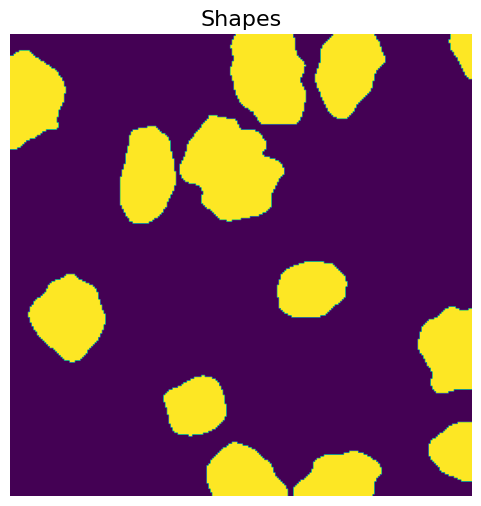

In [75]:
from perlin_noise import PerlinNoise
def perlin():
    noise = PerlinNoise(octaves=10)
    h = 256
    w = 256
    mask = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            mask[i, j] = noise([(i / h)*0.15, (j / w)*0.15])

    # Normalize to range 0.7–1.3
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = 0.7 + mask * 0.6
    return mask



In [8]:
#bg_noise = np.abs(np.random.normal(0,1,(256,256)))
bg_noise = np.zeros((256,256))
cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
final_img = np.zeros((256,256))
final_img = np.where(image==1,cell_1_noise,bg_noise)
#Illumination 
noise = perlin()
final_img += noise*3
#Gaussian smoothin
final_img = gaussian_filter(final_img,sigma = 2)

#Poisson shot noise
poisson = np.random.poisson(final_img,size=(256,256))
final_img += poisson*0.5


## Testing stuff

In [ ]:
def add_camera_noise(final_img,
                     exposure=20.0,     # photons per image intensity unit (higher -> stronger shot noise)
                     gain=1.0,          # electrons per photon (or conversion factor, often 1)
                     read_noise_sigma=2.0,  # Gaussian read noise (in electrons)
                     clip_range=(0, None)):


    signal = np.clip(final_img, 0, None)

    expected_photons = signal * exposure

    photons = np.random.poisson(expected_photons)

    electrons = photons * gain

    noisy_electrons = electrons + np.random.normal(0, read_noise_sigma, electrons.shape)

    noisy_image = noisy_electrons / (exposure * gain)

    noisy_image = np.clip(noisy_image, clip_range[0], clip_range[1] if clip_range[1] is not None else noisy_image.max())

    return noisy_image

In [16]:
image_test = add_camera_noise(final_img,
                         exposure=30.0,        # increase -> more photons -> relatively less Poisson noise
                         gain=1.0,
                         read_noise_sigma=1.5)

In [ ]:
def add_correlated_noise(img, strength=0.15, beta=1.5):
   
    h, w = img.shape
    noise = np.random.normal(0, 1, (h, w))

    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    f = np.sqrt(fx*fx + fy*fy)
    f[0,0] = 1 

    filt = 1 / (f**beta)
    colored = np.real(np.fft.ifft2(np.fft.fft2(noise) * filt))
    colored = (colored - colored.min()) / (colored.max() - colored.min())

    return img + colored * strength

In [24]:
def add_internal_texture(img, mask):
    texture = gaussian_filter(np.random.normal(0, 1, img.shape), sigma=3)
    return img + texture * 0.15 * mask

In [27]:
def airy_psf(img, radius=1.5):
    from scipy.special import j1
    h, w = img.shape
    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    r = np.sqrt(fx*fx + fy*fy)
    psf = (2 * j1(2*np.pi*radius*r) / (2*np.pi*radius*r + 1e-6))
    filtered = np.fft.ifft2(np.fft.fft2(img) * psf)
    return np.real(filtered)

In [ ]:
def smooth_mask(mask, sigma=2.0, edge_softness=12):
    blurred = gaussian_filter(mask.astype(float), sigma=sigma)
    blurred = (blurred - blurred.min()) / (blurred.max() - blurred.min())
    smooth = 1 / (1 + np.exp(-edge_softness * (blurred - 0.5)))
    return smooth

In [91]:
img = image
bg_noise = np.zeros((256,256))
cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
#Soft edges
soft = smooth_mask(mask)
img = bg_noise * (1 - soft) + cell_1_noise * soft
#Internal texture
img = add_internal_texture(img, mask)
#Perlin noise
illum = perlin()
img += illum*3.5
#Noise 
img = airy_psf(img)
# Poisson noise
img = add_camera_noise(img,exposure=10,gain=1,read_noise_sigma=2)
img = add_correlated_noise(img, strength=0.08, beta=1.4)
img = gaussian_filter(img,sigma = 0.5)

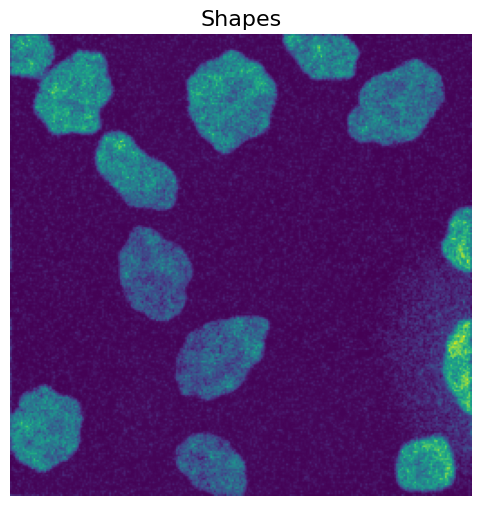

In [92]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax1.imshow(img)
ax1.set_title('Shapes',fontsize=16)
ax1.axis('off')
plt.show()

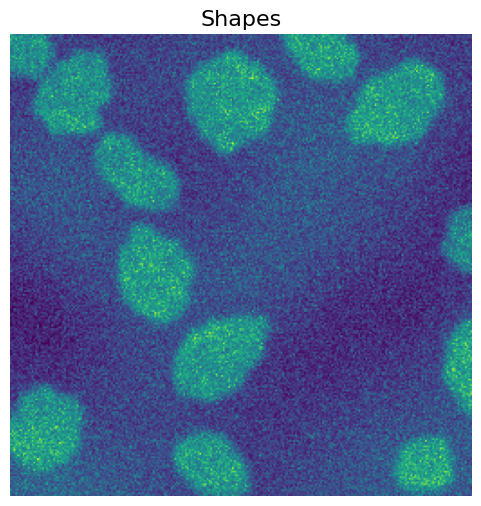

In [23]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax1.imshow(final_img)
ax1.set_title('Shapes',fontsize=16)
ax1.axis('off')
plt.show()

In [83]:
def save_image(image,mask,path):
    from skimage import io, util
    import os

    image_u8 = util.img_as_ubyte(image/np.max(np.abs(image)))
    io.imsave(os.path.join('dataset/generated_cells','images',  f"{path}.png"), image_u8)
    mask_u8 = util.img_as_ubyte(mask/np.max(np.abs(mask)))
    io.imsave(os.path.join('dataset/generated_cells','masks',  f"{path}.png"), mask_u8)

    image = image.astype(np.float32)
    io.imsave(os.path.join('dataset/generated_cells','images',  f"{path}.tif"), image)
    mask = mask.astype(np.float32)
    io.imsave(os.path.join('dataset/generated_cells','masks',  f"{path}.tif"), mask)

In [84]:
save_image(img,mask,"image_2")